## Notebook to create a rainfall-runoff model using data driven methods

**General Description**

The following notebook contains the code to create, train, validate, and test a rainfall-runoff model using an LSTM network architecture. The code allows for the creation of single-basin models but is conceptualized to create regional models. The code is intended as an initial introduction to the topic, prioritizing interpretabilityover modularity.

The logic of the code is heavily based on [Neural Hydrology](https://doi.org/10.21105/joss.04050) [1]. For a more flexible, robust, and modular implementation of deep learning methods in hydrological modeling, we advise the use of Neural Hydrology. 

**Experiment Details**
- In this example we use the LSTM architecture, to create a regional rainfall-runoff model for basins from the [Caravan](https://doi.org/10.5281/zenodo.10968468) [2] dataset. Refer Readme in data folder  for more information on the expected data structure

**Authors:**
- Ashish Manoj J (ashish.manoj@kit.edu)

**References:**

[1]: Kratzert, F., Gauch, M., Nearing, G., & Klotz, D. (2022). NeuralHydrology – A Python library for deep learning research in hydrology. Journal of Open Source Software, 7, 4050. https://doi.org/10.21105/joss.04050

[2]: Kratzert, F. et al. Caravan - A global community dataset for large-sample hydrology. Sci. Data 10, 61 (2023).
https://doi.org/10.1038/s41597-023-01975-w



In [1]:
# Import necessary packages
import pickle
import random
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

sys.path.append("..")
# Import classes and functions from other files
from hy2dl.aux_functions.functions_evaluation import nse
from hy2dl.aux_functions.functions_training import nse_basin_averaged
from hy2dl.aux_functions.utils import Optimizer, create_folder, set_random_seed, upload_to_device, write_report
from hy2dl.datasetzoo.caravan import CARAVAN as Datasetclass
from hy2dl.modelzoo.cudalstm import CudaLSTM as modelclass

Part 1. Initialize information

In [2]:
# Define experiment nae
experiment_name = "LSTM_CARAVAN"

# paths to access the information
path_entities_training = "../data/basin_id/basins_caravan_7.txt"
path_entities_evaluation = "../data/basin_id/basins_caravan_7.txt"
path_data = '/pfs/data5/home/kit/iwu/as2023/dataset/01_europe_flood/Caravan/'

#path_data = "../data/CAMELS_GB"


# dynamic forcings and target
dynamic_input = ['total_precipitation_sum', 'temperature_2m_mean', 'volumetric_soil_water_layer_2_mean']
target = ['streamflow']

# static attributes that will be used. If one is not using static_inputs, initialize the variable as an empty list.
static_input = ['area', 'p_mean','ele_mt_sav','frac_snow']

# time periods
training_period = ["1980-10-01", "1997-12-31"]
validation_period = ["1975-10-01", "1980-09-30"]
testing_period = ["1998-01-01", "2008-12-31"]

# model configuration
model_configuration = {
    "n_dynamic_channels_lstm": len(dynamic_input),
    "no_of_layers": 1,
    "seq_length": 365,
    "hidden_size": 64,
    "batch_size_training": 256,
    "batch_size_evaluation": 1024,
    "no_of_epochs": 30,
    "dropout_rate": 0.4,
    "learning_rate": {1: 1e-3, 10: 5e-4, 20: 1e-4},
    "set_forget_gate": 3,
    "validate_every": 10,
    "validate_n_random_basins": -1,
}

# device to train the model
running_device = "gpu"  # cpu or gpu

# define random seed
seed = 110

# colorblind friendly palette
color_palette = {"observed": "#377eb8","simulated": "#4daf4a"}

Part 2. Calculate additional information necessary to run the model

In [3]:
# Create folder to store the results
path_save_folder = "../results/" + experiment_name + "_seed_" + str(seed)
create_folder(folder_path=path_save_folder)

Folder '../results/LSTM_CARAVAN_seed_110' already exists.


In [4]:
# check if model will be run in gpu or cpu and define device
if running_device == "gpu":
    print(torch.cuda.get_device_name(0))
    device = "cuda:0"
elif running_device == "cpu":
    device = "cpu"

Tesla V100-SXM2-32GB


In [5]:
# include information about input size for each frequency
if isinstance(dynamic_input, list):
    model_configuration["dynamic_input_size"] = len(dynamic_input)
elif isinstance(dynamic_input, dict):
    model_configuration["dynamic_input_size"] = {key: len(value) for key, value in dynamic_input.items()}

# include information about input size for lstm
model_configuration["input_size_lstm"] = model_configuration["n_dynamic_channels_lstm"] + len(static_input)

# if I am processing multiple frequencies and do not have custom dynamic embeddings for each frequency, I add an
# additional channel that will be used as a flag to indicate the frequency.
if model_configuration.get("custom_freq_processing") and not model_configuration.get("dynamic_embeddings"):
    model_configuration["input_size_lstm"] = model_configuration["input_size_lstm"] + 1

# If predict_last_n was not defined, we initialize it as 1
if not model_configuration.get("predict_last_n"):
    model_configuration["predict_last_n"] = 1

# Check connection between predict_last_n and unique_prediction_blocks. If predict_last_n is larger than 1, and
# unique_prediction_blocks is False, we change for evaluation purposes predict_last_n to 1. This avoid having
# multiple predictions for the same time step due to the overlap of the sequences.
if model_configuration.get("predict_last_n", 1) > 1 and not model_configuration.get("unique_prediction_blocks"):
    print(
        (
            "Warning: predict_last_n > 1 and unique_prediction_blocks = False."
            + " This creates overlapping sequences during evaluation. To avoid this, predict_last_n will be changed to"
            + " 1 during evaluation (validation / testing). This will not affect the training process."
        )
    )
    model_configuration["predict_last_n_evaluation"] = 1
else:
    model_configuration["predict_last_n_evaluation"] = model_configuration.get("predict_last_n", 1)

Part 3. Class to create the dataset object used in training

In [6]:
# Dataset training
training_dataset = Datasetclass(
    dynamic_input=dynamic_input,
    target=target,
    sequence_length=model_configuration["seq_length"],
    time_period=training_period,
    path_data=path_data,
    path_entities=path_entities_training,
    check_NaN=True,
    static_input=static_input,
)

training_dataset.calculate_basin_std()
training_dataset.calculate_global_statistics(path_save_scaler=path_save_folder)
training_dataset.standardize_data()

In [7]:
# Dataloader training
train_loader = DataLoader(
    dataset=training_dataset,
    batch_size=model_configuration["batch_size_training"],
    shuffle=True,
    drop_last=True,
    collate_fn=training_dataset.collate_fn,
)

# Print details of a loader´s sample to see that our format is correct
print("Number of batches in training: ", len(train_loader))
print("\nSample batch details:")
print(f"{'Key':<12} | {'Shape':<20}")
print("-" * 35)
# Loop through the sample dictionary and print the shape of each element
for key, value in next(iter(train_loader)).items():
    print(f"{key:<12} | {str(value.shape):<20}")

Number of batches in training:  168

Sample batch details:
Key          | Shape               
-----------------------------------
x_d          | torch.Size([256, 365, 3])
x_s          | torch.Size([256, 4])
y_obs        | torch.Size([256, 1, 1])
basin_std    | torch.Size([256, 1, 1])
basin        | (256,)              
date         | (256, 1)            


Part 4. Create dataset for validation

In [8]:
# In evaluation (validation and testing) we will create an individual dataset per basin. This will give us more 
# flexibility
entities_ids = np.loadtxt(path_entities_evaluation, dtype="str").tolist()
entities_ids = [entities_ids] if isinstance(entities_ids, str) else entities_ids
validation_dataset = {}
for entity in entities_ids:
    dataset = Datasetclass(
        dynamic_input=dynamic_input,
        target=target,
        sequence_length=model_configuration["seq_length"],
        time_period=validation_period,
        path_data=path_data,
        entity=entity,
        check_NaN=False,
        static_input=static_input,
    )

    dataset.scaler = training_dataset.scaler
    dataset.standardize_data(standardize_output=False)
    validation_dataset[entity] = dataset

Part 5. Train Model

In [10]:
# construct model
set_random_seed(seed=seed)
model = modelclass(model_configuration=model_configuration).to(device)

# optimizer
optimizer = Optimizer(model=model, model_configuration=model_configuration) 

# set forget gate to 3 to ensure that the model is capable to learn long term dependencies
model.lstm.bias_hh_l0.data[model_configuration["hidden_size"] : 2 * model_configuration["hidden_size"]] = (
    model_configuration["set_forget_gate"]
)

training_time = time.time()
# Loop through the different epochs
for epoch in range(1, model_configuration["no_of_epochs"] + 1):
    epoch_start_time = time.time()
    total_loss = []
    # Training -------------------------------------------------------------------------------------------------------
    model.train()
    for idx, sample in enumerate(train_loader):
        # maximum iterations per epoch
        if (
            model_configuration.get("max_updates_per_epoch") is not None
            and idx >= model_configuration["max_updates_per_epoch"]
        ):
            break

        sample = upload_to_device(sample, device)  # upload tensors to device
        optimizer.optimizer.zero_grad()  # sets gradients of weigths and bias to zero
        pred = model(sample)  # forward call

        loss = nse_basin_averaged(y_sim=pred["y_hat"], y_obs=sample["y_obs"], per_basin_target_std=sample["basin_std"])

        loss.backward()  # backpropagates
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)  # clip gradients
        optimizer.optimizer.step()  # update weights
        total_loss.append(loss.item())

        # remove from cuda
        del sample, pred
        torch.cuda.empty_cache()

    # training report
    report = f'Epoch: {epoch:<2} | Loss training: {"%.3f "% (np.mean(total_loss))}'

    # Validation -----------------------------------------------------------------------------------------------------
    if epoch % model_configuration["validate_every"] == 0:
        model.eval()
        validation_results = {}
        with torch.no_grad():
            # If we define validate_n_random_basins as 0 or negative, we take all the basins
            if model_configuration["validate_n_random_basins"] <= 0:
                validation_basin_ids = validation_dataset.keys()
            else:
                keys = list(validation_dataset.keys())
                validation_basin_ids = random.sample(keys, model_configuration["validate_n_random_basins"])

            # go through each basin that will be used for validation
            for basin in validation_basin_ids:
                loader = DataLoader(
                    dataset=validation_dataset[basin],
                    batch_size=model_configuration["batch_size_evaluation"],
                    shuffle=False,
                    drop_last=False,
                    collate_fn=validation_dataset[basin].collate_fn,
                )

                df_ts = pd.DataFrame()
                for sample in loader:
                    sample = upload_to_device(sample, device)
                    pred = model(sample)
                    # backtransformed information
                    y_sim = pred["y_hat"] * validation_dataset[basin].scaler["y_std"].to(device) + validation_dataset[
                        basin
                    ].scaler["y_mean"].to(device)

                    # join results in a dataframe and store them in a dictionary (is easier to plot later)
                    df = pd.DataFrame(
                        {
                            "y_obs": sample["y_obs"].flatten().cpu().detach(),
                            "y_sim": y_sim[:, -model_configuration["predict_last_n_evaluation"] :, :]
                            .flatten()
                            .cpu()
                            .detach(),
                        },
                        index=pd.to_datetime(sample["date"].flatten()),
                    )

                    df_ts = pd.concat([df_ts, df], axis=0)

                    # remove from cuda
                    del sample, pred, y_sim
                    torch.cuda.empty_cache()

                validation_results[basin] = df_ts

            # average loss validation
            loss_validation = nse(df_results=validation_results)
            report += f'| NSE validation: {"%.3f "% (loss_validation)}'

    # save model after every epoch
    path_saved_model = path_save_folder + "/epoch_" + str(epoch)
    torch.save(model.state_dict(), path_saved_model)

    # print epoch report
    report += (
        f'| Epoch time: {"%.1f "% (time.time()-epoch_start_time)} s | '
        f'LR:{"%.5f "% (optimizer.optimizer.param_groups[0]["lr"])}'
    )
    print(report)
    write_report(file_path=path_save_folder + "/run_progress.txt", text=report)
    # modify learning rate
    optimizer.update_optimizer_lr(epoch=epoch)

# print final report
report = f'Total training time: {"%.1f "% (time.time()-training_time)} s'
print(report)
write_report(file_path=path_save_folder + "/run_progress.txt", text=report)

Epoch: 1  | Loss training: 0.268 | Epoch time: 9.7  s | LR:0.00100 
Epoch: 2  | Loss training: 0.184 | Epoch time: 3.2  s | LR:0.00100 
Epoch: 3  | Loss training: 0.153 | Epoch time: 3.1  s | LR:0.00100 
Epoch: 4  | Loss training: 0.143 | Epoch time: 3.1  s | LR:0.00100 
Epoch: 5  | Loss training: 0.133 | Epoch time: 3.1  s | LR:0.00100 
Epoch: 6  | Loss training: 0.127 | Epoch time: 3.1  s | LR:0.00100 
Epoch: 7  | Loss training: 0.122 | Epoch time: 3.1  s | LR:0.00100 
Epoch: 8  | Loss training: 0.119 | Epoch time: 3.2  s | LR:0.00100 
Epoch: 9  | Loss training: 0.113 | Epoch time: 3.1  s | LR:0.00100 
Epoch: 10 | Loss training: 0.108 | NSE validation: 0.667 | Epoch time: 3.5  s | LR:0.00100 
Epoch: 11 | Loss training: 0.102 | Epoch time: 3.0  s | LR:0.00050 
Epoch: 12 | Loss training: 0.099 | Epoch time: 3.0  s | LR:0.00050 
Epoch: 13 | Loss training: 0.099 | Epoch time: 3.2  s | LR:0.00050 
Epoch: 14 | Loss training: 0.098 | Epoch time: 2.8  s | LR:0.00050 
Epoch: 15 | Loss trainin

Part 6. Test LSTM

In [11]:
# In case I already trained an LSTM I can re-construct the model
# model = modelclass(model_configuration=model_configuration).to(device)
# model.load_state_dict(torch.load(path_save_folder + "/epoch_20", map_location=device))

# We can read the training scaler or read a previously stored one
scaler = training_dataset.scaler
# with open(path_save_folder + "/scaler.pickle", "rb") as file:
#    scaler = pickle.load(file)

In [12]:
# In evaluation (validation and testing) we will create an individual dataset per basin. This will give us more 
# flexibility
entities_ids = np.loadtxt(path_entities_evaluation, dtype="str").tolist()
entities_ids = [entities_ids] if isinstance(entities_ids, str) else entities_ids
testing_dataset = {}
for entity in entities_ids:
    dataset = Datasetclass(
        dynamic_input=dynamic_input,
        target=target,
        sequence_length=model_configuration["seq_length"],
        time_period=testing_period,
        path_data=path_data,
        entity=entity,
        check_NaN=False,
        static_input=static_input,
    )

    dataset.scaler = scaler
    dataset.standardize_data(standardize_output=False)
    testing_dataset[entity] = dataset

In [13]:
model.eval()
test_results = {}
with torch.no_grad():
    for basin, dataset in testing_dataset.items():
        loader = DataLoader(
            dataset=dataset,
            batch_size=model_configuration["batch_size_evaluation"],
            shuffle=False,
            drop_last=False,
            collate_fn=testing_dataset[basin].collate_fn,
        )

        df_ts = pd.DataFrame()
        for sample in loader:
            sample = upload_to_device(sample, device)  # upload tensors to device
            pred = model(sample)
            # backtransformed information
            y_sim = pred["y_hat"] * dataset.scaler["y_std"].to(device) + dataset.scaler["y_mean"].to(device)

            # join results in a dataframe and store them in a dictionary (is easier to plot later)
            df = pd.DataFrame(
                {
                    "y_obs": sample["y_obs"].flatten().cpu().detach(),
                    "y_sim": y_sim[:, -model_configuration["predict_last_n_evaluation"] :, :].flatten().cpu().detach(),
                },
                index=pd.to_datetime(sample["date"].flatten()),
            )

            df_ts = pd.concat([df_ts, df], axis=0)

            # remove from cuda
            del sample, pred, y_sim
            torch.cuda.empty_cache()

        test_results[basin] = df_ts

# Save results as a pickle file
with open(path_save_folder + "/test_results.pickle", "wb") as f:
    pickle.dump(test_results, f)

Part 7. Initial analysis

In [14]:
# Loss testing
loss_testing = nse(df_results=test_results, average=False)
df_NSE = pd.DataFrame(data={"basin_id": testing_dataset.keys(), "NSE": np.round(loss_testing, 3)})
df_NSE = df_NSE.set_index("basin_id")
df_NSE.to_csv(path_save_folder + "/NSE_testing.csv", index=True, header=True)

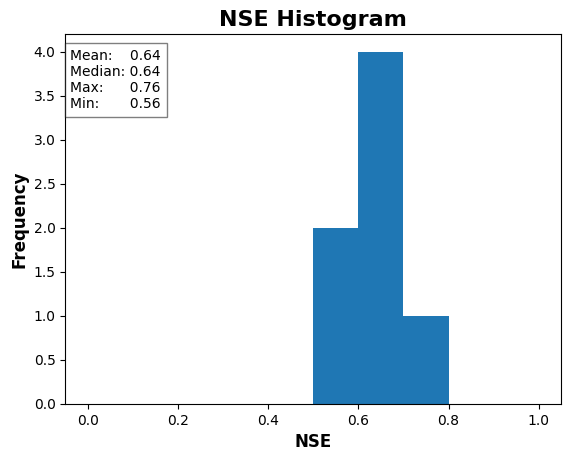

In [15]:
# Plot the histogram
plt.hist(df_NSE["NSE"], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Add NSE statistics to the plot
plt.text(
    0.01,
    0.8,
    (
        f'Mean: {"%.2f" % df_NSE["NSE"].mean():>7}\n'
        f'Median: {"%.2f" % df_NSE["NSE"].median():>0}\n'
        f'Max: {"%.2f" % df_NSE["NSE"].max():>9}\n'
        f'Min: {"%.2f" % df_NSE["NSE"].min():>10}'
    ),
    transform=plt.gca().transAxes,
    bbox=dict(facecolor="white", alpha=0.5),
)

# Format plot
plt.rcParams["figure.figsize"] = (20, 5)
plt.xlabel("NSE", fontsize=12, fontweight="bold")
plt.ylabel("Frequency", fontsize=12, fontweight="bold")
plt.title("NSE Histogram", fontsize=16, fontweight="bold")
# plt.savefig(save_folder+"/NSE_Histogram.png", bbox_inches="tight", pad_inches=0)
plt.show()

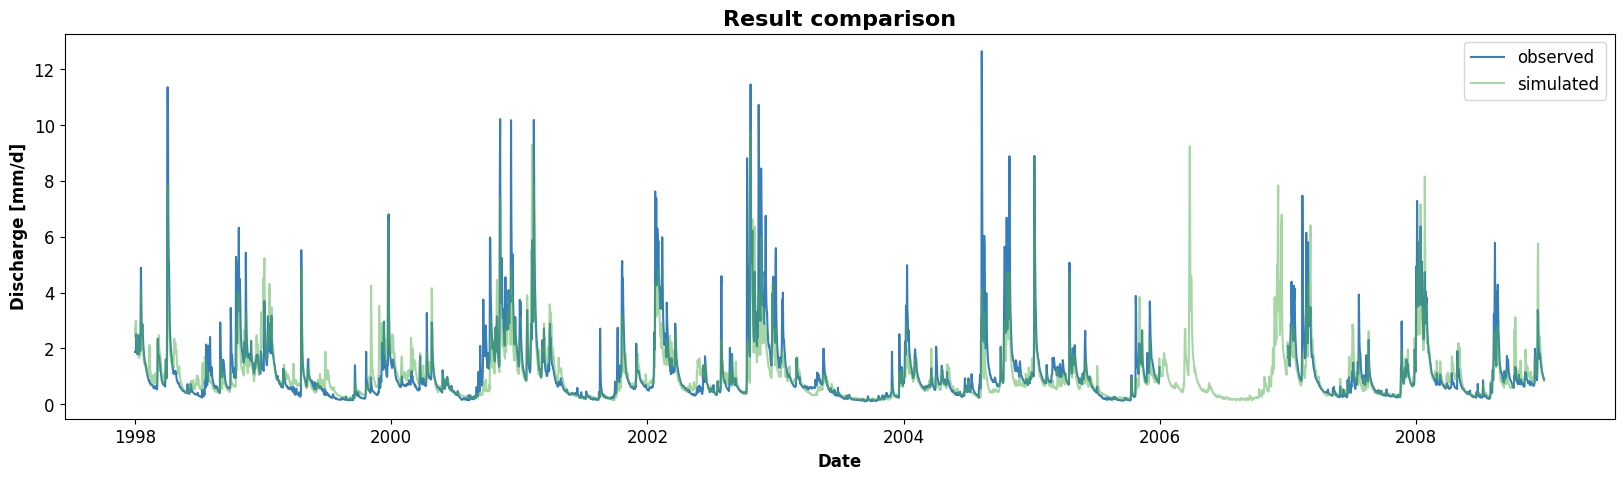

In [16]:
# Plot simulated and observed discharges
basin_to_analyze = "camelsgb_14002"

plt.plot(test_results[basin_to_analyze]["y_obs"], label="observed", color=color_palette["observed"])
plt.plot(test_results[basin_to_analyze]["y_sim"], label="simulated", alpha=0.5, color=color_palette["simulated"])

# Format plot
plt.xlabel("Date", fontsize=12, fontweight="bold")
plt.ylabel("Discharge [mm/d]", fontsize=12, fontweight="bold")
plt.title("Result comparison", fontsize=16, fontweight="bold")
plt.tick_params(axis="both", which="major", labelsize=12)
plt.legend(loc="upper right", fontsize=12)

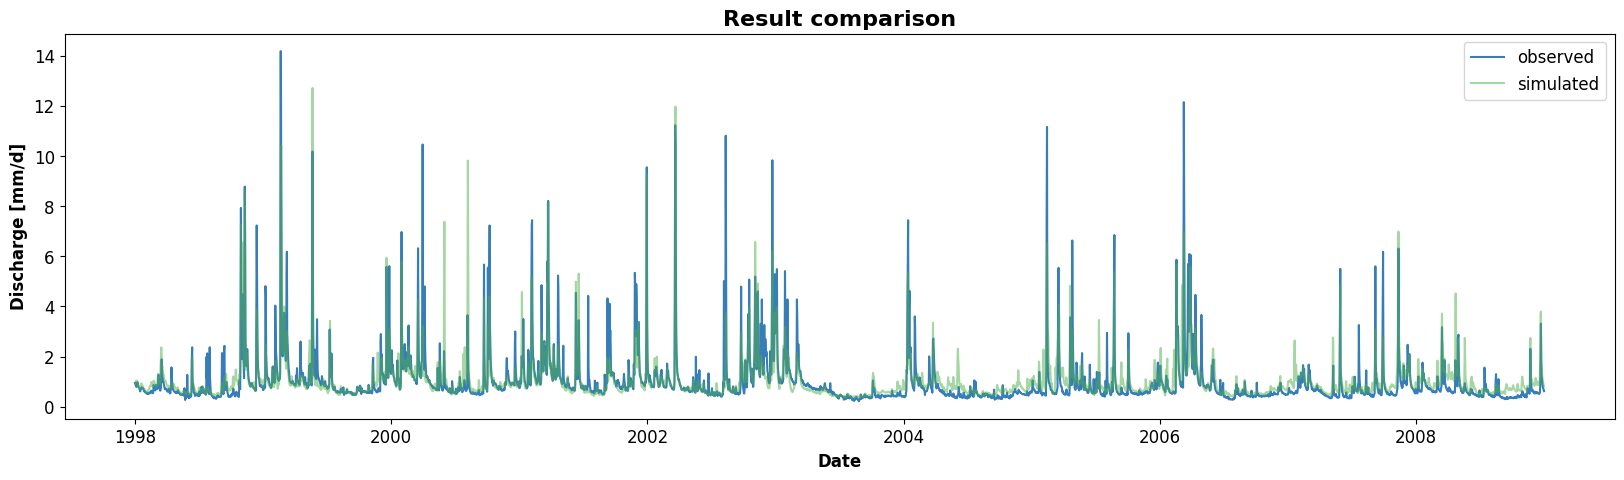

In [17]:
# Plot simulated and observed discharges
basin_to_analyze = "GRDC_6342660"

plt.plot(test_results[basin_to_analyze]["y_obs"], label="observed", color=color_palette["observed"])
plt.plot(test_results[basin_to_analyze]["y_sim"], label="simulated", alpha=0.5, color=color_palette["simulated"])

# Format plot
plt.xlabel("Date", fontsize=12, fontweight="bold")
plt.ylabel("Discharge [mm/d]", fontsize=12, fontweight="bold")
plt.title("Result comparison", fontsize=16, fontweight="bold")
plt.tick_params(axis="both", which="major", labelsize=12)
plt.legend(loc="upper right", fontsize=12)